In [1]:
# !pip install 'zarr<3'
# !pip install timm


In [2]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


## Data Loading

In [4]:
# Cell 3: Import and create dataloaders
from dataset import Config, create_dataloaders

# Just use the correct relative path from your working directory
config = Config("configs/training/config_fold2.yaml")  # Note: "configs" not "config"
config.print_config()

train_loader, val_loader, test_loader = create_dataloaders(config)
print("\n✅ Ready to use!")

CRC DATASET CONFIGURATION
Config File: configs/training/config_fold2.yaml
Zarr Base: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/ORION-CRC/zarr_data
Cache: ./cache/multimodal_dataset_cache_fold2.pkl
Strategy: memory

📊 Data Splits:
  Train: 33 samples
  Val: 9 samples
  Test: 8 samples

🔄 DataLoader:
  Batch Size: 4
  Num Workers: 0
  Pin Memory: True

🎨 Augmentation:
  Training: True
  Probability: 0.0

🎯 HV Maps:
  Generate: True
  Method: pannuke
  HE Nuclei: True
  HE Cells: True
  MIF Nuclei: True
  MIF Cells: True

🔍 Filtering:
  Min Instances: 0
  Filter Empty: True

CREATING DATALOADERS
Strategy: memory
Use Cache: True
Batch Size: 4
Num Workers: 0

Train split: 27 CRC + 6 Xenium samples
Val split: 7 CRC + 2 Xenium samples
Test split: 7 CRC + 1 Xenium samples

📦 Loading from cache: ./cache/combined_cache_train_fc66ad2e.pkl
📦 Loaded 4194 patches from cache
📦 Loading from cache: ./cache/combined_cache_val_3f9beb52.pkl
📦 Loaded 643 patches from cache
📦 Loading from cac

## Train

In [3]:
# # Cell 1: Import
# from vitaminp import VitaminPDual, VitaminPTrainer
# import torch

# # Cell 3: Initialize model
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = VitaminPDual(model_size='base', dropout_rate=0.3, freeze_backbone=False)

# # Cell 4: Initialize trainer
# trainer = VitaminPTrainer(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     device=device,
#     lr=1e-4,
#     weight_decay=1e-4,
#     fold=2,
#     use_wandb=False,
#     project_name="vitamin-p-channel_shuffling",
#     run_name="VitaminPDual-base_fold2",
#     checkpoint_dir="checkpoints"
# )

# # Cell 5: Train
# trainer.train(epochs=250, use_augmentations=True)

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Building H&E encoder with DINOv2-base
Building MIF encoder with DINOv2-base
Building shared encoder with DINOv2-base
✓ VitaminPDual initialized with base backbone
  Embed dim: 768 | Decoder dims: [768, 384, 192, 96]
Training VitaminPDual-BASE
Epochs: 250 | LR: 0.0001
Augmentations: True


Training:   0%|                                                                                                    | 0/1048 [00:00<?, ?it/s]


KeyboardInterrupt: 

## Predictions

In [16]:
# ============================================================================
# SINGLE SAMPLE VISUALIZATION - DUAL ENCODER MODEL
# ============================================================================
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from vitaminp import VitaminPDual, SimplePreprocessing
from postprocessing import process_model_outputs
import random

# ============================================================================
# MODEL CONFIGURATION
# ============================================================================
MODEL_SIZE = 'base'
DUAL_MODEL_PATH = 'checkpoints/vitamin_p_dual_base_fold2_best.pth'  # Update with your actual path

# ============================================================================
# LOAD MODEL
# ============================================================================
print("="*80)
print(f"{'LOADING DUAL ENCODER MODEL':^80}")
print("="*80)
print(f"Model: VitaminPDual-{MODEL_SIZE.upper()}")
print(f"Checkpoint: {DUAL_MODEL_PATH}")
print("-"*80)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dual = VitaminPDual(model_size=MODEL_SIZE, dropout_rate=0.3, freeze_backbone=False)
checkpoint_dual = torch.load(DUAL_MODEL_PATH, map_location=device)
model_dual.load_state_dict(checkpoint_dual)
model_dual.eval()
model_dual = model_dual.to(device)
print(f"✓ Model loaded successfully")
print(f"Device: {device}")
print("="*80)

# ============================================================================
# PREPROCESSING
# ============================================================================
preprocessor = SimplePreprocessing()

# ============================================================================
# GET A RANDOM SAMPLE
# ============================================================================
batch_idx = random.randint(0, len(test_loader) - 1)
for i, batch in enumerate(test_loader):
    if i == batch_idx:
        break

idx = random.randint(0, batch['he_image'].shape[0] - 1)

print(f"\n{'='*80}")
print(f"SAMPLE IDENTIFICATION")
print(f"{'='*80}")
print(f"Batch Index: {batch_idx} / {len(test_loader)}")
print(f"Sample Index in Batch: {idx} / {batch['he_image'].shape[0]}")
global_idx = batch_idx * batch['he_image'].shape[0] + idx
print(f"Global Sample Index: {global_idx}")
print(f"{'='*80}")

# ============================================================================
# PREPARE INPUTS
# ============================================================================
he_img = batch['he_image'][idx].to(device)
mif_img = batch['mif_image'][idx].to(device)

# Ground truth HV maps
he_nuclei_hv_gt = batch['he_nuclei_hv'][idx].cpu().numpy()
he_cell_hv_gt = batch['he_cell_hv'][idx].cpu().numpy()
mif_nuclei_hv_gt = batch['mif_nuclei_hv'][idx].cpu().numpy()
mif_cell_hv_gt = batch['mif_cell_hv'][idx].cpu().numpy()

# Prepare inputs for model
he_input = he_img.unsqueeze(0)
mif_input = mif_img.unsqueeze(0)
he_input = preprocessor.percentile_normalize(he_input)
mif_input = preprocessor.percentile_normalize(mif_input)

# ============================================================================
# PREDICT WITH DUAL ENCODER MODEL
# ============================================================================
print(f"\nRunning predictions...")

with torch.no_grad():
    outputs_dual = model_dual(he_input, mif_input)
    
    # H&E predictions
    n_hv_pred_he = outputs_dual['he_nuclei_hv'][0].cpu().numpy()
    c_hv_pred_he = outputs_dual['he_cell_hv'][0].cpu().numpy()
    n_mask_pred_he = (outputs_dual['he_nuclei_seg'][0, 0] > 0.5).float().cpu().numpy()
    c_mask_pred_he = (outputs_dual['he_cell_seg'][0, 0] > 0.5).float().cpu().numpy()
    
    # MIF predictions
    n_hv_pred_mif = outputs_dual['mif_nuclei_hv'][0].cpu().numpy()
    c_hv_pred_mif = outputs_dual['mif_cell_hv'][0].cpu().numpy()
    n_mask_pred_mif = (outputs_dual['mif_nuclei_seg'][0, 0] > 0.5).float().cpu().numpy()
    c_mask_pred_mif = (outputs_dual['mif_cell_seg'][0, 0] > 0.5).float().cpu().numpy()

print("✓ Predictions complete")

# ============================================================================
# PREPARE IMAGES FOR VISUALIZATION
# ============================================================================
img_he = he_img.cpu().permute(1, 2, 0).numpy()
img_he = np.clip(img_he, 0, 1)

img_mif = mif_img.cpu().permute(1, 2, 0).numpy()
img_mif = np.clip(img_mif, 0, 1)

# Convert MIF to RGB for visualization
if img_mif.shape[2] == 2:
    img_mif_rgb = np.zeros((img_mif.shape[0], img_mif.shape[1], 3), dtype=img_mif.dtype)
    img_mif_rgb[:, :, 0] = img_mif[:, :, 0]  # Red channel
    img_mif_rgb[:, :, 1] = img_mif[:, :, 1]  # Green channel
    img_mif_rgb = np.clip(img_mif_rgb * 1.5, 0, 1)  # Brighten
    img_mif = img_mif_rgb

# Create HV magnitude maps
# Ground truth
n_hv_gt_he_mag = np.sqrt(he_nuclei_hv_gt[0]**2 + he_nuclei_hv_gt[1]**2)
c_hv_gt_he_mag = np.sqrt(he_cell_hv_gt[0]**2 + he_cell_hv_gt[1]**2)
n_hv_gt_mif_mag = np.sqrt(mif_nuclei_hv_gt[0]**2 + mif_nuclei_hv_gt[1]**2)
c_hv_gt_mif_mag = np.sqrt(mif_cell_hv_gt[0]**2 + mif_cell_hv_gt[1]**2)

# Predictions
n_hv_pred_he_mag = np.sqrt(n_hv_pred_he[0]**2 + n_hv_pred_he[1]**2)
c_hv_pred_he_mag = np.sqrt(c_hv_pred_he[0]**2 + c_hv_pred_he[1]**2)
n_hv_pred_mif_mag = np.sqrt(n_hv_pred_mif[0]**2 + n_hv_pred_mif[1]**2)
c_hv_pred_mif_mag = np.sqrt(c_hv_pred_mif[0]**2 + c_hv_pred_mif[1]**2)

# ============================================================================
# POST-PROCESSING TO GET INSTANCES
# ============================================================================
print("\nPost-processing H&E predictions...")
print("  Processing H&E nuclei instances...")
nuclei_inst_he, nuclei_info_he, num_nuclei_he = process_model_outputs(
    seg_pred=n_mask_pred_he,
    h_map=n_hv_pred_he[0],
    v_map=n_hv_pred_he[1],
    magnification=40
)
print(f"  ✓ Detected {num_nuclei_he} H&E nuclei instances")

print("  Processing H&E cell instances...")
cell_inst_he, cell_info_he, num_cells_he = process_model_outputs(
    seg_pred=c_mask_pred_he,
    h_map=c_hv_pred_he[0],
    v_map=c_hv_pred_he[1],
    magnification=40
)
print(f"  ✓ Detected {num_cells_he} H&E cell instances")

print("\nPost-processing MIF predictions...")
print("  Processing MIF nuclei instances...")
nuclei_inst_mif, nuclei_info_mif, num_nuclei_mif = process_model_outputs(
    seg_pred=n_mask_pred_mif,
    h_map=n_hv_pred_mif[0],
    v_map=n_hv_pred_mif[1],
    magnification=40
)
print(f"  ✓ Detected {num_nuclei_mif} MIF nuclei instances")

print("  Processing MIF cell instances...")
cell_inst_mif, cell_info_mif, num_cells_mif = process_model_outputs(
    seg_pred=c_mask_pred_mif,
    h_map=c_hv_pred_mif[0],
    v_map=c_hv_pred_mif[1],
    magnification=40
)
print(f"  ✓ Detected {num_cells_mif} MIF cell instances")

# ============================================================================
# DRAW CONTOURS FUNCTION
# ============================================================================
def draw_contours_simple(image, inst_info_dict, color=(0, 255, 0), thickness=2):
    """Draw instance contours on image"""
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    if len(image.shape) == 2:
        output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    elif image.shape[2] == 3:
        output = image.copy()
    
    for inst_id, inst_data in inst_info_dict.items():
        contour = inst_data['contour']
        if contour.shape[0] >= 3:
            cv2.drawContours(output, [contour], -1, color, thickness)
        
        centroid = inst_data['centroid'].astype(int)
        cv2.circle(output, tuple(centroid), 3, (255, 255, 0), -1)
    
    return output

# Draw contours
img_he_uint8 = (img_he * 255).astype(np.uint8) if img_he.max() <= 1.0 else img_he.astype(np.uint8)
img_mif_uint8 = (img_mif * 255).astype(np.uint8) if img_mif.max() <= 1.0 else img_mif.astype(np.uint8)

# H&E contours (BLUE for nuclei, GREEN for cells)
nuclei_contours_he = draw_contours_simple(img_he_uint8.copy(), nuclei_info_he, color=(0, 100, 255), thickness=2)
cell_contours_he = draw_contours_simple(img_he_uint8.copy(), cell_info_he, color=(0, 255, 0), thickness=2)

# MIF contours (BLUE for nuclei, GREEN for cells)
nuclei_contours_mif = draw_contours_simple(img_mif_uint8.copy(), nuclei_info_mif, color=(0, 100, 255), thickness=2)
cell_contours_mif = draw_contours_simple(img_mif_uint8.copy(), cell_info_mif, color=(0, 255, 0), thickness=2)

# ============================================================================
# VISUALIZATION - NUCLEI (H&E vs MIF)
# ============================================================================
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

# ROW 1: H&E NUCLEI
axes[0, 0].imshow(img_he)
axes[0, 0].set_title('H&E Input Image', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

im1 = axes[0, 1].imshow(n_hv_gt_he_mag, cmap='viridis', vmin=0, vmax=1.5)
axes[0, 1].set_title(f'H&E Nuclei HV GT\nMean: {n_hv_gt_he_mag.mean():.3f}', fontsize=11)
axes[0, 1].axis('off')
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)

im2 = axes[0, 2].imshow(n_hv_pred_he_mag, cmap='viridis', vmin=0, vmax=1.5)
axes[0, 2].set_title(f'H&E Nuclei HV Pred\nMean: {n_hv_pred_he_mag.mean():.3f}', fontsize=11)
axes[0, 2].axis('off')
plt.colorbar(im2, ax=axes[0, 2], fraction=0.046)

axes[0, 3].imshow(nuclei_contours_he)
axes[0, 3].set_title(f'H&E Nuclei Boundaries (BLUE)\n({num_nuclei_he} instances)', fontsize=11, fontweight='bold')
axes[0, 3].axis('off')

# ROW 2: MIF NUCLEI
axes[1, 0].imshow(img_mif)
axes[1, 0].set_title('MIF Input Image (Brightened)', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

im3 = axes[1, 1].imshow(n_hv_gt_mif_mag, cmap='viridis', vmin=0, vmax=1.5)
axes[1, 1].set_title(f'MIF Nuclei HV GT\nMean: {n_hv_gt_mif_mag.mean():.3f}', fontsize=11)
axes[1, 1].axis('off')
plt.colorbar(im3, ax=axes[1, 1], fraction=0.046)

im4 = axes[1, 2].imshow(n_hv_pred_mif_mag, cmap='viridis', vmin=0, vmax=1.5)
axes[1, 2].set_title(f'MIF Nuclei HV Pred\nMean: {n_hv_pred_mif_mag.mean():.3f}', fontsize=11)
axes[1, 2].axis('off')
plt.colorbar(im4, ax=axes[1, 2], fraction=0.046)

axes[1, 3].imshow(nuclei_contours_mif)
axes[1, 3].set_title(f'MIF Nuclei Boundaries (BLUE)\n({num_nuclei_mif} instances)', fontsize=11, fontweight='bold')
axes[1, 3].axis('off')

plt.suptitle(f'NUCLEI SEGMENTATION - VitaminPDual-{MODEL_SIZE.upper()} | Batch {batch_idx}, Sample {idx}', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION - CELLS (H&E vs MIF)
# ============================================================================
fig2, axes2 = plt.subplots(2, 4, figsize=(24, 12))

# ROW 1: H&E CELLS
axes2[0, 0].imshow(img_he)
axes2[0, 0].set_title('H&E Input Image', fontsize=12, fontweight='bold')
axes2[0, 0].axis('off')

im5 = axes2[0, 1].imshow(c_hv_gt_he_mag, cmap='viridis', vmin=0, vmax=1.5)
axes2[0, 1].set_title(f'H&E Cell HV GT\nMean: {c_hv_gt_he_mag.mean():.3f}', fontsize=11)
axes2[0, 1].axis('off')
plt.colorbar(im5, ax=axes2[0, 1], fraction=0.046)

im6 = axes2[0, 2].imshow(c_hv_pred_he_mag, cmap='viridis', vmin=0, vmax=1.5)
axes2[0, 2].set_title(f'H&E Cell HV Pred\nMean: {c_hv_pred_he_mag.mean():.3f}', fontsize=11)
axes2[0, 2].axis('off')
plt.colorbar(im6, ax=axes2[0, 2], fraction=0.046)

axes2[0, 3].imshow(cell_contours_he)
axes2[0, 3].set_title(f'H&E Cell Boundaries (GREEN)\n({num_cells_he} instances)', fontsize=11, fontweight='bold')
axes2[0, 3].axis('off')

# ROW 2: MIF CELLS
axes2[1, 0].imshow(img_mif)
axes2[1, 0].set_title('MIF Input Image (Brightened)', fontsize=12, fontweight='bold')
axes2[1, 0].axis('off')

im7 = axes2[1, 1].imshow(c_hv_gt_mif_mag, cmap='viridis', vmin=0, vmax=1.5)
axes2[1, 1].set_title(f'MIF Cell HV GT\nMean: {c_hv_gt_mif_mag.mean():.3f}', fontsize=11)
axes2[1, 1].axis('off')
plt.colorbar(im7, ax=axes2[1, 1], fraction=0.046)

im8 = axes2[1, 2].imshow(c_hv_pred_mif_mag, cmap='viridis', vmin=0, vmax=1.5)
axes2[1, 2].set_title(f'MIF Cell HV Pred\nMean: {c_hv_pred_mif_mag.mean():.3f}', fontsize=11)
axes2[1, 2].axis('off')
plt.colorbar(im8, ax=axes2[1, 2], fraction=0.046)

axes2[1, 3].imshow(cell_contours_mif)
axes2[1, 3].set_title(f'MIF Cell Boundaries (GREEN)\n({num_cells_mif} instances)', fontsize=11, fontweight='bold')
axes2[1, 3].axis('off')

plt.suptitle(f'CELL SEGMENTATION - VitaminPDual-{MODEL_SIZE.upper()} | Batch {batch_idx}, Sample {idx}', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# STATISTICS SUMMARY
# ============================================================================
nuclei_error_he = np.abs(n_hv_pred_he_mag - n_hv_gt_he_mag)
cell_error_he = np.abs(c_hv_pred_he_mag - c_hv_gt_he_mag)
nuclei_error_mif = np.abs(n_hv_pred_mif_mag - n_hv_gt_mif_mag)
cell_error_mif = np.abs(c_hv_pred_mif_mag - c_hv_gt_mif_mag)

print(f"\n{'='*80}")
print(f"STATISTICS SUMMARY")
print(f"{'='*80}")
print(f"H&E  NUCLEI: {num_nuclei_he} instances | HV MAE: {nuclei_error_he.mean():.4f}")
print(f"H&E  CELLS:  {num_cells_he} instances | HV MAE: {cell_error_he.mean():.4f}")
print(f"MIF  NUCLEI: {num_nuclei_mif} instances | HV MAE: {nuclei_error_mif.mean():.4f}")
print(f"MIF  CELLS:  {num_cells_mif} instances | HV MAE: {cell_error_mif.mean():.4f}")
print(f"{'='*80}")

                           LOADING DUAL ENCODER MODEL                           
Model: VitaminPDual-BASE
Checkpoint: checkpoints/vitamin_p_dual_base_fold2_best.pth
--------------------------------------------------------------------------------
Building H&E encoder with DINOv2-base
Building MIF encoder with DINOv2-base
Building shared encoder with DINOv2-base
✓ VitaminPDual initialized with base backbone
  Embed dim: 768 | Decoder dims: [768, 384, 192, 96]
✓ Model loaded successfully
Device: cuda

SAMPLE IDENTIFICATION
Batch Index: 74 / 103
Sample Index in Batch: 3 / 4
Global Sample Index: 299

Running predictions...
✓ Predictions complete

Post-processing H&E predictions...
  Processing H&E nuclei instances...
  ✓ Detected 144 H&E nuclei instances
  Processing H&E cell instances...
  ✓ Detected 181 H&E cell instances

Post-processing MIF predictions...
  Processing MIF nuclei instances...
  ✓ Detected 187 MIF nuclei instances
  Processing MIF cell instances...
  ✓ Detected 176 MIF ce

## Metrics

In [13]:
import torch
from metrics import (
    dice_coefficient, 
    iou_score, 
    panoptic_quality,
    aggregated_jaccard_index,
    compute_batch_metrics,
    print_metrics
)
import numpy as np
from vitaminp import VitaminPDual, SimplePreprocessing
from postprocessing import process_model_outputs

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ========== LOAD TRAINED DUAL MODEL ==========
print("\n📦 Loading trained dual model...")

model = VitaminPDual(model_size='base', dropout_rate=0.3, freeze_backbone=False).to(device)
checkpoint_path = "checkpoints/vitamin_p_dual_base_fold2_best.pth"  # Update with your actual path
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

print(f"✅ Loaded checkpoint: {checkpoint_path}")
print(f"✅ Model: VitaminPDual-Base")

# ========== PREPROCESSING ==========
preprocessor = SimplePreprocessing()

# ========== EVALUATE ON TEST DATA ==========
print("\n🧪 Evaluating on test set...")
model.eval()

all_metrics = {
    # H&E metrics
    'he_nuclei_dice': [], 'he_nuclei_iou': [],
    'he_cell_dice': [], 'he_cell_iou': [],
    # MIF metrics
    'mif_nuclei_dice': [], 'mif_nuclei_iou': [],
    'mif_cell_dice': [], 'mif_cell_iou': []
}

with torch.no_grad():
    for batch_idx, batch in enumerate(train_loader):
        
        # ===== Prepare inputs =====
        he_img = batch['he_image'].to(device)
        mif_img = batch['mif_image'].to(device)
        
        # Normalize
        he_img = preprocessor.percentile_normalize(he_img)
        mif_img = preprocessor.percentile_normalize(mif_img)
        
        # Ground truth masks
        he_nuclei_mask_gt = batch['he_nuclei_mask'].float().unsqueeze(1).to(device)
        he_cell_mask_gt = batch['he_cell_mask'].float().unsqueeze(1).to(device)
        mif_nuclei_mask_gt = batch['mif_nuclei_mask'].float().unsqueeze(1).to(device)
        mif_cell_mask_gt = batch['mif_cell_mask'].float().unsqueeze(1).to(device)
        
        # ===== Forward pass (Dual Model) =====
        outputs = model(he_img, mif_img)
        
        # ===== H&E Predictions =====
        pred_nuclei_he = (outputs['he_nuclei_seg'] > 0.5).float()
        pred_cell_he = (outputs['he_cell_seg'] > 0.5).float()
        
        # Compute H&E metrics
        he_nuclei_dice = dice_coefficient(pred_nuclei_he, he_nuclei_mask_gt)
        he_nuclei_iou = iou_score(pred_nuclei_he, he_nuclei_mask_gt)
        he_cell_dice = dice_coefficient(pred_cell_he, he_cell_mask_gt)
        he_cell_iou = iou_score(pred_cell_he, he_cell_mask_gt)
        
        all_metrics['he_nuclei_dice'].append(he_nuclei_dice)
        all_metrics['he_nuclei_iou'].append(he_nuclei_iou)
        all_metrics['he_cell_dice'].append(he_cell_dice)
        all_metrics['he_cell_iou'].append(he_cell_iou)
        
        # ===== MIF Predictions =====
        pred_nuclei_mif = (outputs['mif_nuclei_seg'] > 0.5).float()
        pred_cell_mif = (outputs['mif_cell_seg'] > 0.5).float()
        
        # Compute MIF metrics
        mif_nuclei_dice = dice_coefficient(pred_nuclei_mif, mif_nuclei_mask_gt)
        mif_nuclei_iou = iou_score(pred_nuclei_mif, mif_nuclei_mask_gt)
        mif_cell_dice = dice_coefficient(pred_cell_mif, mif_cell_mask_gt)
        mif_cell_iou = iou_score(pred_cell_mif, mif_cell_mask_gt)
        
        all_metrics['mif_nuclei_dice'].append(mif_nuclei_dice)
        all_metrics['mif_nuclei_iou'].append(mif_nuclei_iou)
        all_metrics['mif_cell_dice'].append(mif_cell_dice)
        all_metrics['mif_cell_iou'].append(mif_cell_iou)
        
        # Print progress every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"Processed {batch_idx + 1}/{len(test_loader)} batches...")

# ========== AGGREGATE RESULTS ==========
print("\n" + "="*80)
print("📊 DUAL MODEL TEST SET RESULTS")
print("="*80)

print("\n🔬 H&E Performance:")
he_nuclei_dice_mean = sum(all_metrics['he_nuclei_dice'])/len(all_metrics['he_nuclei_dice'])
he_nuclei_dice_std = torch.tensor(all_metrics['he_nuclei_dice']).std()
he_nuclei_iou_mean = sum(all_metrics['he_nuclei_iou'])/len(all_metrics['he_nuclei_iou'])
he_nuclei_iou_std = torch.tensor(all_metrics['he_nuclei_iou']).std()
he_cell_dice_mean = sum(all_metrics['he_cell_dice'])/len(all_metrics['he_cell_dice'])
he_cell_dice_std = torch.tensor(all_metrics['he_cell_dice']).std()
he_cell_iou_mean = sum(all_metrics['he_cell_iou'])/len(all_metrics['he_cell_iou'])
he_cell_iou_std = torch.tensor(all_metrics['he_cell_iou']).std()

print(f"  Nuclei Dice: {he_nuclei_dice_mean:.4f} ± {he_nuclei_dice_std:.4f}")
print(f"  Nuclei IoU:  {he_nuclei_iou_mean:.4f} ± {he_nuclei_iou_std:.4f}")
print(f"  Cell Dice:   {he_cell_dice_mean:.4f} ± {he_cell_dice_std:.4f}")
print(f"  Cell IoU:    {he_cell_iou_mean:.4f} ± {he_cell_iou_std:.4f}")

print("\n🧬 MIF Performance:")
mif_nuclei_dice_mean = sum(all_metrics['mif_nuclei_dice'])/len(all_metrics['mif_nuclei_dice'])
mif_nuclei_dice_std = torch.tensor(all_metrics['mif_nuclei_dice']).std()
mif_nuclei_iou_mean = sum(all_metrics['mif_nuclei_iou'])/len(all_metrics['mif_nuclei_iou'])
mif_nuclei_iou_std = torch.tensor(all_metrics['mif_nuclei_iou']).std()
mif_cell_dice_mean = sum(all_metrics['mif_cell_dice'])/len(all_metrics['mif_cell_dice'])
mif_cell_dice_std = torch.tensor(all_metrics['mif_cell_dice']).std()
mif_cell_iou_mean = sum(all_metrics['mif_cell_iou'])/len(all_metrics['mif_cell_iou'])
mif_cell_iou_std = torch.tensor(all_metrics['mif_cell_iou']).std()

print(f"  Nuclei Dice: {mif_nuclei_dice_mean:.4f} ± {mif_nuclei_dice_std:.4f}")
print(f"  Nuclei IoU:  {mif_nuclei_iou_mean:.4f} ± {mif_nuclei_iou_std:.4f}")
print(f"  Cell Dice:   {mif_cell_dice_mean:.4f} ± {mif_cell_dice_std:.4f}")
print(f"  Cell IoU:    {mif_cell_iou_mean:.4f} ± {mif_cell_iou_std:.4f}")

print("\n" + "="*80)
print("📈 SUMMARY:")
print("="*80)
print(f"Total batches processed: {len(test_loader)}")
print(f"Total samples: {len(all_metrics['he_nuclei_dice'])}")

# Overall averages
he_avg = (he_nuclei_dice_mean + he_cell_dice_mean) / 2
mif_avg = (mif_nuclei_dice_mean + mif_cell_dice_mean) / 2
overall_avg = (he_avg + mif_avg) / 2

print(f"\nAverage H&E Dice:  {he_avg:.4f}")
print(f"Average MIF Dice:  {mif_avg:.4f}")
print(f"Overall Dice:      {overall_avg:.4f}")
print("="*80)

# ========== SINGLE BATCH DETAILED VIEW ==========
print("\n🔍 Single batch detailed view (first sample):")
with torch.no_grad():
    batch = next(iter(test_loader))
    
    he_img = batch['he_image'].to(device)
    mif_img = batch['mif_image'].to(device)
    he_img = preprocessor.percentile_normalize(he_img)
    mif_img = preprocessor.percentile_normalize(mif_img)
    
    outputs = model(he_img, mif_img)
    
    # H&E sample
    pred_nuclei_he = outputs['he_nuclei_seg'][0].cpu()
    gt_nuclei_he = batch['he_nuclei_mask'][0].unsqueeze(0).cpu()
    
    pred_cell_he = outputs['he_cell_seg'][0].cpu()
    gt_cell_he = batch['he_cell_mask'][0].unsqueeze(0).cpu()
    
    # MIF sample
    pred_nuclei_mif = outputs['mif_nuclei_seg'][0].cpu()
    gt_nuclei_mif = batch['mif_nuclei_mask'][0].unsqueeze(0).cpu()
    
    pred_cell_mif = outputs['mif_cell_seg'][0].cpu()
    gt_cell_mif = batch['mif_cell_mask'][0].unsqueeze(0).cpu()
    
    # Compute metrics
    he_n_dice = dice_coefficient(pred_nuclei_he, gt_nuclei_he)
    he_n_iou = iou_score(pred_nuclei_he, gt_nuclei_he)
    he_c_dice = dice_coefficient(pred_cell_he, gt_cell_he)
    he_c_iou = iou_score(pred_cell_he, gt_cell_he)
    
    mif_n_dice = dice_coefficient(pred_nuclei_mif, gt_nuclei_mif)
    mif_n_iou = iou_score(pred_nuclei_mif, gt_nuclei_mif)
    mif_c_dice = dice_coefficient(pred_cell_mif, gt_cell_mif)
    mif_c_iou = iou_score(pred_cell_mif, gt_cell_mif)
    
    print(f"\nH&E (first sample):")
    print(f"  Nuclei - Dice: {he_n_dice:.4f}, IoU: {he_n_iou:.4f}")
    print(f"  Cell   - Dice: {he_c_dice:.4f}, IoU: {he_c_iou:.4f}")
    
    print(f"\nMIF (first sample):")
    print(f"  Nuclei - Dice: {mif_n_dice:.4f}, IoU: {mif_n_iou:.4f}")
    print(f"  Cell   - Dice: {mif_c_dice:.4f}, IoU: {mif_c_iou:.4f}")

Using device: cuda

📦 Loading trained dual model...
Building H&E encoder with DINOv2-base
Building MIF encoder with DINOv2-base
Building shared encoder with DINOv2-base
✓ VitaminPDual initialized with base backbone
  Embed dim: 768 | Decoder dims: [768, 384, 192, 96]
✅ Loaded checkpoint: checkpoints/vitamin_p_dual_base_fold2_best.pth
✅ Model: VitaminPDual-Base

🧪 Evaluating on test set...
Processed 10/103 batches...
Processed 20/103 batches...
Processed 30/103 batches...
Processed 40/103 batches...
Processed 50/103 batches...
Processed 60/103 batches...
Processed 70/103 batches...
Processed 80/103 batches...
Processed 90/103 batches...
Processed 100/103 batches...
Processed 110/103 batches...
Processed 120/103 batches...
Processed 130/103 batches...
Processed 140/103 batches...
Processed 150/103 batches...
Processed 160/103 batches...
Processed 170/103 batches...
Processed 180/103 batches...
Processed 190/103 batches...
Processed 200/103 batches...
Processed 210/103 batches...
Processe

## Figure 2

Building H&E encoder with DINOv2-base
Building MIF encoder with DINOv2-base
Building shared encoder with DINOv2-base
✓ VitaminPDual initialized with base backbone
  Embed dim: 768 | Decoder dims: [768, 384, 192, 96]
Selected batch 31, sample 3
Processing H&E nuclei instances...
✓ Detected 270 H&E nuclei instances
Processing H&E cell instances...
✓ Detected 245 H&E cell instances
Processing MIF nuclei instances...
✓ Detected 263 MIF nuclei instances
Processing MIF cell instances...
✓ Detected 247 MIF cell instances


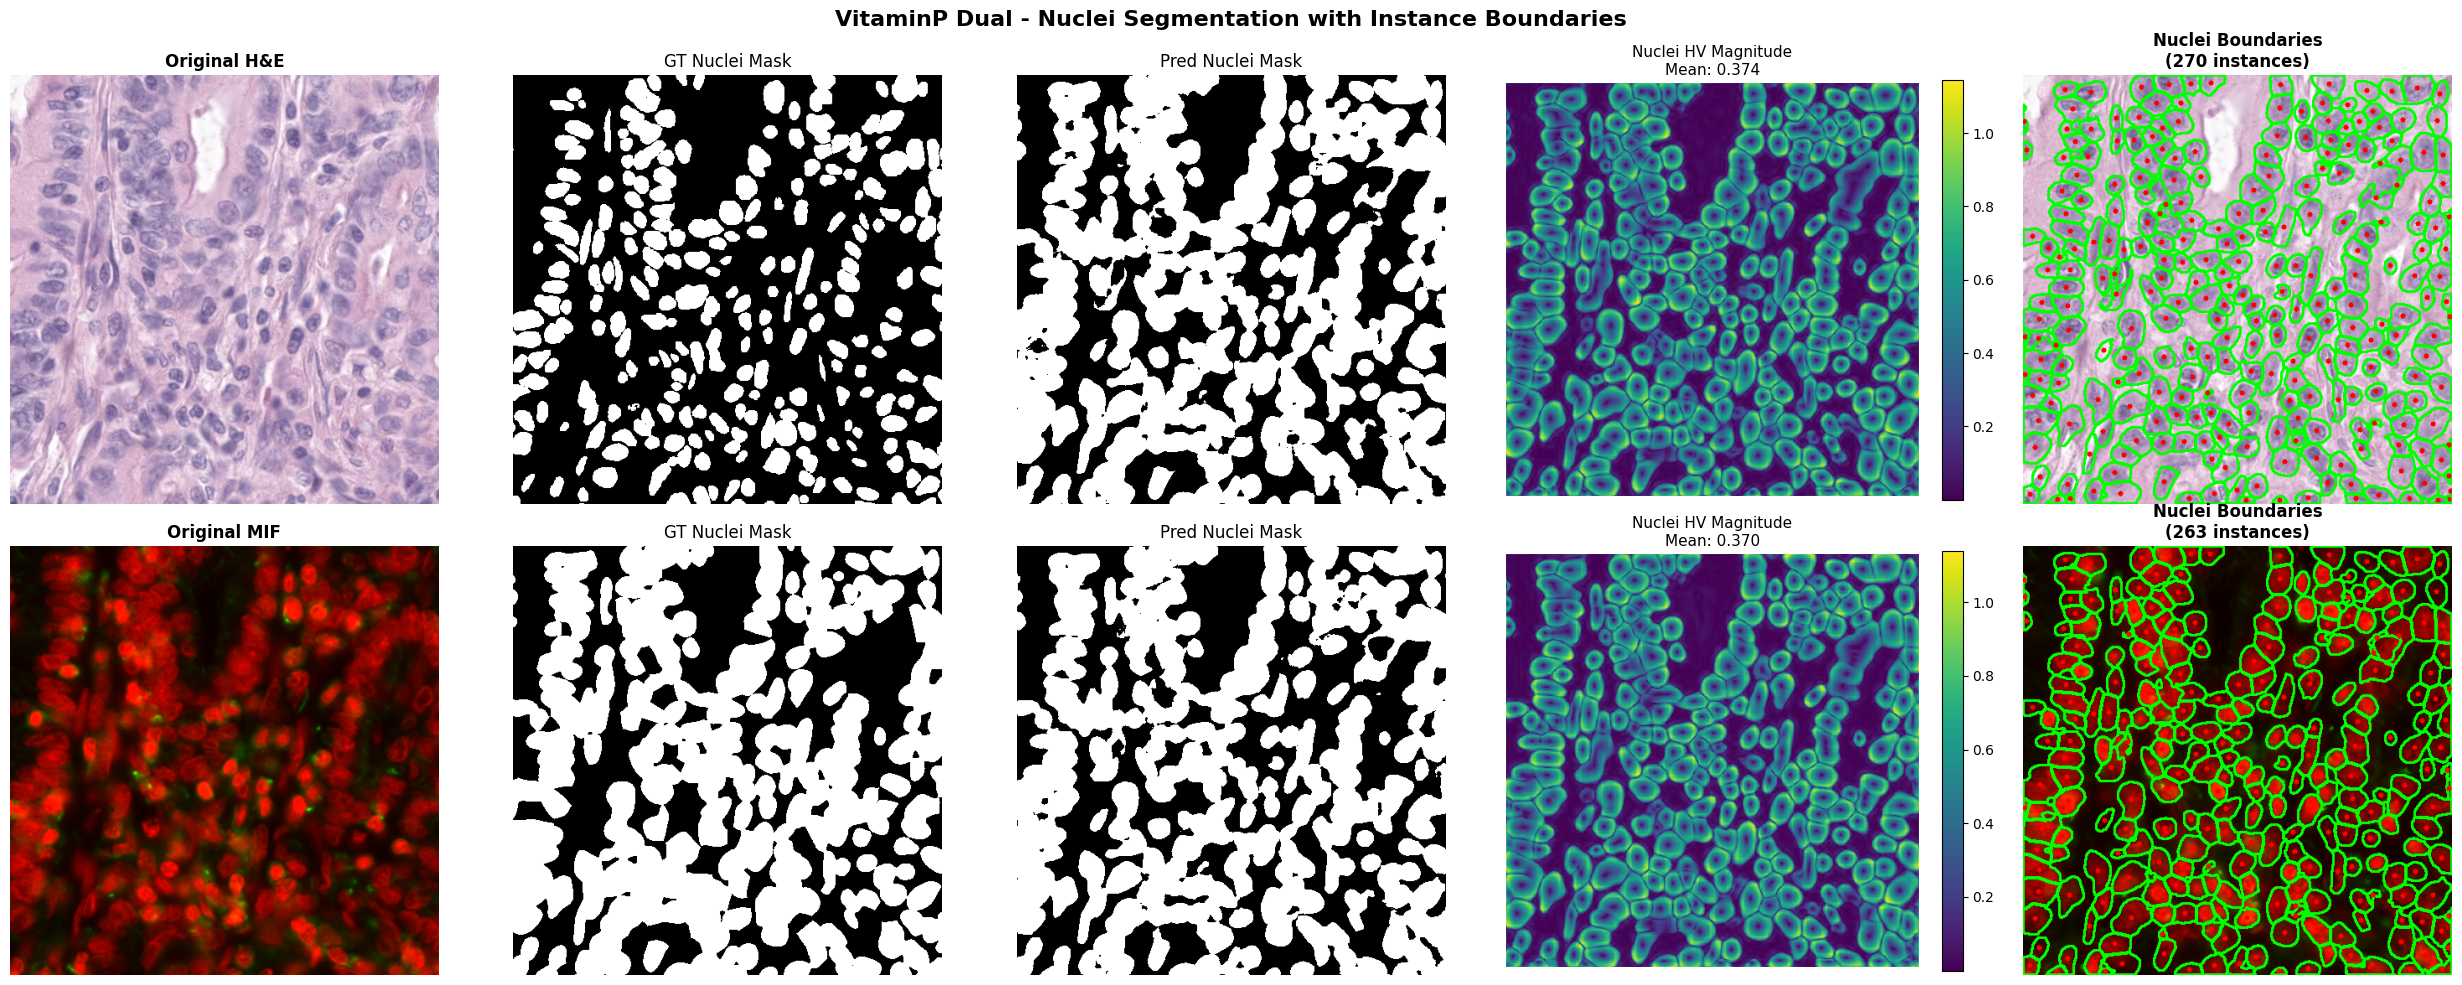


📊 NUCLEI METRICS:
  H&E Nuclei Dice: 0.6472 | 270 instances detected
  MIF Nuclei Dice: 0.9051 | 263 instances detected


In [22]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from vitaminp import VitaminPDual, SimplePreprocessing
from postprocessing import process_model_outputs
from metrics import dice_coefficient
import random

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VitaminPDual(model_size='base', dropout_rate=0.3, freeze_backbone=False).to(device)
model.load_state_dict(torch.load("checkpoints/vitamin_p_dual_base_fold21_best.pth", map_location=device))
model.eval()

preprocessor = SimplePreprocessing()

# Get a random batch and random sample from it
batch_idx = random.randint(0, len(test_loader) - 1)
for i, batch in enumerate(test_loader):
    if i == batch_idx:
        break

idx = random.randint(0, batch['he_image'].shape[0] - 1)
print(f"Selected batch {batch_idx}, sample {idx}")

# Prepare inputs
he_img = batch['he_image'][idx].unsqueeze(0).to(device)
mif_img = batch['mif_image'][idx].unsqueeze(0).to(device)
he_img = preprocessor.percentile_normalize(he_img)
mif_img = preprocessor.percentile_normalize(mif_img)

# Get predictions
# Get predictions
with torch.no_grad():
    outputs = model(he_img, mif_img)

    # H&E predictions
    pred_nuclei_mask_he = (outputs['he_nuclei_seg'][0, 0] > 0.5).float().cpu().numpy()
    pred_nuclei_hv_he = outputs['he_nuclei_hv'][0].cpu().numpy()
    pred_cell_mask_he = (outputs['he_cell_seg'][0, 0] > 0.5).float().cpu().numpy()
    pred_cell_hv_he = outputs['he_cell_hv'][0].cpu().numpy()

    # MIF predictions
    pred_nuclei_mask_mif = (outputs['mif_nuclei_seg'][0, 0] > 0.5).float().cpu().numpy()
    pred_nuclei_hv_mif = outputs['mif_nuclei_hv'][0].cpu().numpy()
    pred_cell_mask_mif = (outputs['mif_cell_seg'][0, 0] > 0.5).float().cpu().numpy()
    pred_cell_hv_mif = outputs['mif_cell_hv'][0].cpu().numpy()

# Ground truth
gt_nuclei_he = batch['he_nuclei_mask'][idx].cpu().numpy()
gt_cell_he = batch['he_cell_mask'][idx].cpu().numpy()
gt_nuclei_mif = batch['mif_nuclei_mask'][idx].cpu().numpy()
gt_cell_mif = batch['mif_cell_mask'][idx].cpu().numpy()
original_he = batch['he_image'][idx].permute(1, 2, 0).cpu().numpy()
original_mif = batch['mif_image'][idx].permute(1, 2, 0).cpu().numpy()

# Convert MIF to RGB for visualization
if original_mif.shape[2] == 2:
    mif_rgb = np.zeros((original_mif.shape[0], original_mif.shape[1], 3), dtype=original_mif.dtype)
    mif_rgb[:, :, 0] = original_mif[:, :, 0]
    mif_rgb[:, :, 1] = original_mif[:, :, 1]
    original_mif = np.clip(mif_rgb * 1.5, 0, 1)

# ============================================================================
# POST-PROCESSING TO GET INSTANCES
# ============================================================================
print("Processing H&E nuclei instances...")
nuclei_inst_he, nuclei_info_he, num_nuclei_he = process_model_outputs(
    seg_pred=pred_nuclei_mask_he,
    h_map=pred_nuclei_hv_he[0],
    v_map=pred_nuclei_hv_he[1],
    magnification=40
)
print(f"✓ Detected {num_nuclei_he} H&E nuclei instances")

print("Processing H&E cell instances...")
cell_inst_he, cell_info_he, num_cells_he = process_model_outputs(
    seg_pred=pred_cell_mask_he,
    h_map=pred_cell_hv_he[0],
    v_map=pred_cell_hv_he[1],
    magnification=40
)
print(f"✓ Detected {num_cells_he} H&E cell instances")

print("Processing MIF nuclei instances...")
nuclei_inst_mif, nuclei_info_mif, num_nuclei_mif = process_model_outputs(
    seg_pred=pred_nuclei_mask_mif,
    h_map=pred_nuclei_hv_mif[0],
    v_map=pred_nuclei_hv_mif[1],
    magnification=40
)
print(f"✓ Detected {num_nuclei_mif} MIF nuclei instances")

print("Processing MIF cell instances...")
cell_inst_mif, cell_info_mif, num_cells_mif = process_model_outputs(
    seg_pred=pred_cell_mask_mif,
    h_map=pred_cell_hv_mif[0],
    v_map=pred_cell_hv_mif[1],
    magnification=40
)
print(f"✓ Detected {num_cells_mif} MIF cell instances")

# ============================================================================
# DRAW CONTOURS FUNCTION
# ============================================================================
def draw_contours_simple(image, inst_info_dict, color=(0, 255, 0), thickness=2):
    """Draw instance contours on image"""
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    if len(image.shape) == 2:
        output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    elif image.shape[2] == 3:
        output = image.copy()
    
    for inst_id, inst_data in inst_info_dict.items():
        contour = inst_data['contour']
        if contour.shape[0] >= 3:
            cv2.drawContours(output, [contour], -1, color, thickness)
        
        centroid = inst_data['centroid'].astype(int)
        cv2.circle(output, tuple(centroid), 3, (255, 0, 0), -1)
    
    return output

# Draw contours
img_he_uint8 = (original_he * 255).astype(np.uint8) if original_he.max() <= 1.0 else original_he.astype(np.uint8)
img_mif_uint8 = (original_mif * 255).astype(np.uint8) if original_mif.max() <= 1.0 else original_mif.astype(np.uint8)

nuclei_contours_he = draw_contours_simple(img_he_uint8.copy(), nuclei_info_he, color=(0, 255, 0), thickness=2)
cell_contours_he = draw_contours_simple(img_he_uint8.copy(), cell_info_he, color=(255, 0, 0), thickness=2)
nuclei_contours_mif = draw_contours_simple(img_mif_uint8.copy(), nuclei_info_mif, color=(0, 255, 0), thickness=2)
cell_contours_mif = draw_contours_simple(img_mif_uint8.copy(), cell_info_mif, color=(255, 0, 0), thickness=2)

# Create HV magnitude maps
nuclei_hv_mag_he = np.sqrt(pred_nuclei_hv_he[0]**2 + pred_nuclei_hv_he[1]**2)
cell_hv_mag_he = np.sqrt(pred_cell_hv_he[0]**2 + pred_cell_hv_he[1]**2)
nuclei_hv_mag_mif = np.sqrt(pred_nuclei_hv_mif[0]**2 + pred_nuclei_hv_mif[1]**2)
cell_hv_mag_mif = np.sqrt(pred_cell_hv_mif[0]**2 + pred_cell_hv_mif[1]**2)

# ============================================================================
# VISUALIZATION - NUCLEI (2x5 grid, Row 1: H&E, Row 2: MIF)
# ============================================================================
fig, axes = plt.subplots(2, 5, figsize=(25, 10))

# Row 1: H&E Nuclei
axes[0, 0].imshow(original_he)
axes[0, 0].set_title('Original H&E', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(gt_nuclei_he, cmap='gray')
axes[0, 1].set_title('GT Nuclei Mask', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(pred_nuclei_mask_he, cmap='gray')
axes[0, 2].set_title('Pred Nuclei Mask', fontsize=12)
axes[0, 2].axis('off')

im1 = axes[0, 3].imshow(nuclei_hv_mag_he, cmap='viridis')
axes[0, 3].set_title(f'Nuclei HV Magnitude\nMean: {nuclei_hv_mag_he.mean():.3f}', fontsize=11)
axes[0, 3].axis('off')
plt.colorbar(im1, ax=axes[0, 3], fraction=0.046)

axes[0, 4].imshow(nuclei_contours_he)
axes[0, 4].set_title(f'Nuclei Boundaries\n({num_nuclei_he} instances)', fontsize=12, fontweight='bold')
axes[0, 4].axis('off')

# Row 2: MIF Nuclei
axes[1, 0].imshow(original_mif)
axes[1, 0].set_title('Original MIF', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(gt_nuclei_mif, cmap='gray')
axes[1, 1].set_title('GT Nuclei Mask', fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(pred_nuclei_mask_mif, cmap='gray')
axes[1, 2].set_title('Pred Nuclei Mask', fontsize=12)
axes[1, 2].axis('off')

im2 = axes[1, 3].imshow(nuclei_hv_mag_mif, cmap='viridis')
axes[1, 3].set_title(f'Nuclei HV Magnitude\nMean: {nuclei_hv_mag_mif.mean():.3f}', fontsize=11)
axes[1, 3].axis('off')
plt.colorbar(im2, ax=axes[1, 3], fraction=0.046)

axes[1, 4].imshow(nuclei_contours_mif)
axes[1, 4].set_title(f'Nuclei Boundaries\n({num_nuclei_mif} instances)', fontsize=12, fontweight='bold')
axes[1, 4].axis('off')

plt.suptitle('VitaminP Dual - Nuclei Segmentation with Instance Boundaries', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print nuclei metrics
nuclei_dice_he = dice_coefficient(torch.from_numpy(pred_nuclei_mask_he).unsqueeze(0), torch.from_numpy(gt_nuclei_he).unsqueeze(0))
nuclei_dice_mif = dice_coefficient(torch.from_numpy(pred_nuclei_mask_mif).unsqueeze(0), torch.from_numpy(gt_nuclei_mif).unsqueeze(0))

print(f"\n📊 NUCLEI METRICS:")
print(f"  H&E Nuclei Dice: {nuclei_dice_he:.4f} | {num_nuclei_he} instances detected")
print(f"  MIF Nuclei Dice: {nuclei_dice_mif:.4f} | {num_nuclei_mif} instances detected")

Running Nuclei-Constrained refinement...
H&E - Original Nuclei: 126 | Refined Cells: 126
MIF - Original Nuclei: 126 | Refined Cells: 126


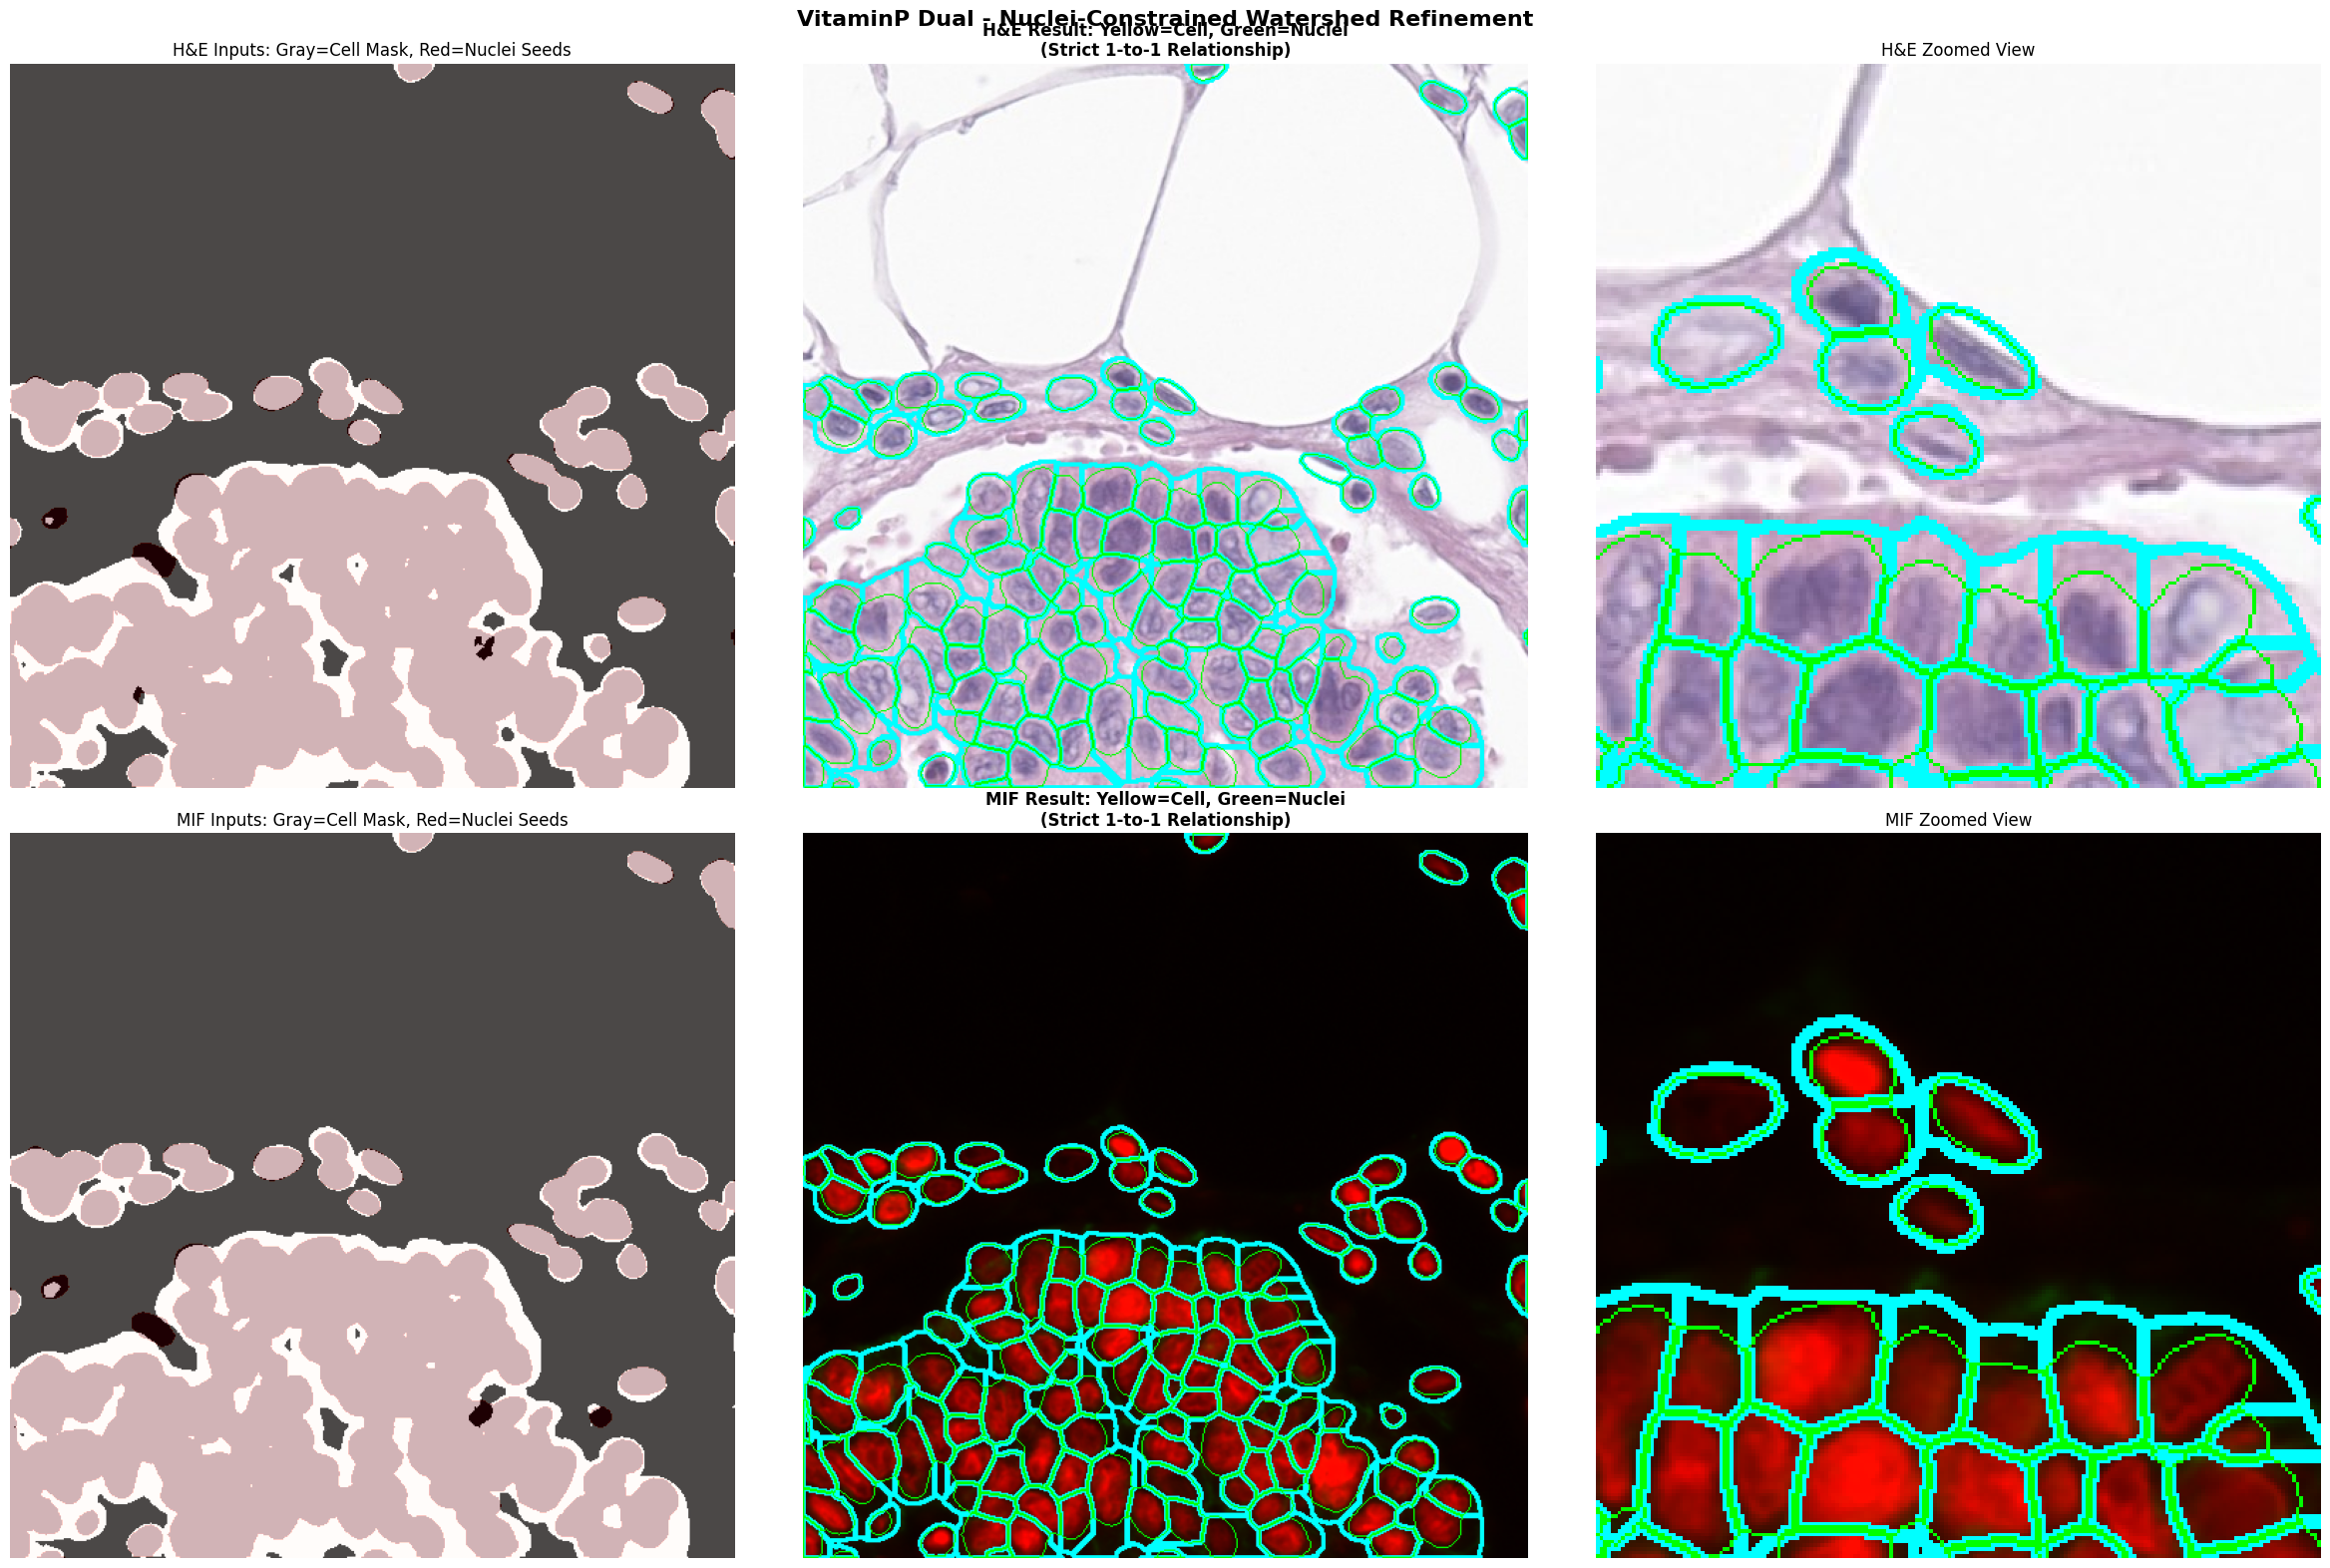

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import watershed
from scipy.ndimage import distance_transform_edt
import cv2

def apply_nuclei_constrained_watershed(nuclei_labels, cell_mask, cell_threshold=0.5):
    """
    1. Markers: Nuclei (Seeds)
    2. Mask: Cell Prediction (The allowed garden size)
    """
    # 1. Prepare Markers (The Nuclei)
    markers = nuclei_labels.astype(int)
    
    # 2. Prepare the Mask (The allowed cell area)
    cell_binary = cell_mask > cell_threshold
    nuclei_binary = markers > 0
    combined_mask = np.logical_or(cell_binary, nuclei_binary)
    
    # 3. Create Energy Landscape
    dist = distance_transform_edt(combined_mask)
    
    # 4. Run Watershed
    constrained_cells = watershed(-dist, markers, mask=combined_mask)
    
    return constrained_cells

# =========================================================
# RUN THE ALGORITHM FOR BOTH MODALITIES
# =========================================================
print("Running Nuclei-Constrained refinement...")

# H&E
refined_cell_labels_he = apply_nuclei_constrained_watershed(
    nuclei_labels=nuclei_inst_he, 
    cell_mask=pred_cell_mask_he,
    cell_threshold=0.5
)
num_refined_he = len(np.unique(refined_cell_labels_he)) - 1

# MIF
refined_cell_labels_mif = apply_nuclei_constrained_watershed(
    nuclei_labels=nuclei_inst_mif, 
    cell_mask=pred_cell_mask_mif,
    cell_threshold=0.5
)
num_refined_mif = len(np.unique(refined_cell_labels_mif)) - 1

print(f"H&E - Original Nuclei: {num_nuclei_he} | Refined Cells: {num_refined_he}")
print(f"MIF - Original Nuclei: {num_nuclei_mif} | Refined Cells: {num_refined_mif}")

# =========================================================
# VISUALIZATION
# =========================================================
def get_contours(label_map):
    contours = []
    ids = np.unique(label_map)
    for i in ids:
        if i == 0: continue
        mask = (label_map == i).astype(np.uint8)
        cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if cnts: contours.append(cnts[0])
    return contours

# Get contours
nuclei_contours_list_he = get_contours(nuclei_inst_he)
refined_cell_contours_he = get_contours(refined_cell_labels_he)
nuclei_contours_list_mif = get_contours(nuclei_inst_mif)
refined_cell_contours_mif = get_contours(refined_cell_labels_mif)

# Create visualization images
vis_img_he = img_he_uint8.copy()
cv2.drawContours(vis_img_he, refined_cell_contours_he, -1, (0, 255, 255), 2)
cv2.drawContours(vis_img_he, nuclei_contours_list_he, -1, (0, 255, 0), 1)

vis_img_mif = img_mif_uint8.copy()
cv2.drawContours(vis_img_mif, refined_cell_contours_mif, -1, (0, 255, 255), 2)
cv2.drawContours(vis_img_mif, nuclei_contours_list_mif, -1, (0, 255, 0), 1)

# Plotting — 2 rows (H&E / MIF), 3 columns (same layout as flex)
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

# Row 1: H&E
axes[0, 0].imshow(pred_cell_mask_he, cmap='gray')
axes[0, 0].imshow(nuclei_inst_he > 0, cmap='Reds', alpha=0.3)
axes[0, 0].set_title('H&E Inputs: Gray=Cell Mask, Red=Nuclei Seeds', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(vis_img_he)
axes[0, 1].set_title(f'H&E Result: Yellow=Cell, Green=Nuclei\n(Strict 1-to-1 Relationship)', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

h, w = original_he.shape[:2]
cy, cx = h // 2, w // 2
zoom_slice = np.s_[cy-100:cy+100, cx-100:cx+100]
axes[0, 2].imshow(vis_img_he[zoom_slice])
axes[0, 2].set_title('H&E Zoomed View', fontsize=12)
axes[0, 2].axis('off')

# Row 2: MIF
axes[1, 0].imshow(pred_cell_mask_mif, cmap='gray')
axes[1, 0].imshow(nuclei_inst_mif > 0, cmap='Reds', alpha=0.3)
axes[1, 0].set_title('MIF Inputs: Gray=Cell Mask, Red=Nuclei Seeds', fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(vis_img_mif)
axes[1, 1].set_title(f'MIF Result: Yellow=Cell, Green=Nuclei\n(Strict 1-to-1 Relationship)', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(vis_img_mif[zoom_slice])
axes[1, 2].set_title('MIF Zoomed View', fontsize=12)
axes[1, 2].axis('off')

plt.suptitle('VitaminP Dual - Nuclei-Constrained Watershed Refinement', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()